# Scalar vs Matrix Kernel PFF: Visualization

This notebook replicates the key insight from **Hu & van Leeuwen (2021) Figures 2-3**:

- **Observed components** converge fast (receive direct information from observations)
- **Unobserved components** converge slow (only indirect information via prior correlations)
- **Scalar kernel** fails when observations are sparse — collapses in observed dimensions
- **Matrix kernel** maintains proper spread by treating each dimension independently

In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Add project to path
import sys
sys.path.insert(0, '..')

from advanced_particle_filter.models.base import StateSpaceModel
from advanced_particle_filter.filters import KernelPFF

# Style settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11

## 1. Model Definition

**Sparse Observation Linear Gaussian SSM**:
- State: $x \in \mathbb{R}^{n_x}$
- Dynamics: $x_{k+1} = x_k + v_k$ (random walk)
- Observation: $y_k = C x_k + w_k$ where $C$ selects only first $n_y$ states

In [2]:
def make_sparse_obs_model(nx: int, ny: int, q: float = 0.1, r: float = 0.01):
    """
    Create sparse observation model.
    
    Args:
        nx: State dimension
        ny: Observation dimension (must be < nx)
        q: Process noise variance
        r: Observation noise variance
    """
    A = np.eye(nx)  # Random walk
    Q = q * np.eye(nx)
    
    # Observe only first ny states
    C = np.zeros((ny, nx))
    for i in range(ny):
        C[i, i] = 1.0
    
    R = r * np.eye(ny)
    m0 = np.zeros(nx)
    P0 = np.eye(nx)
    
    return StateSpaceModel(
        state_dim=nx,
        obs_dim=ny,
        initial_mean=m0,
        initial_cov=P0,
        dynamics_mean=lambda x: x @ A.T,
        dynamics_cov=Q,
        dynamics_jacobian=lambda x: A,
        obs_mean=lambda x: (x @ C.T) if x.ndim > 1 else (C @ x),
        obs_cov=R,
        obs_jacobian=lambda x: C,
    )

## 2. Helper Functions for Visualization

In [3]:
def confidence_ellipse(mean, cov, ax, n_std=2.0, **kwargs):
    """
    Plot confidence ellipse for 2D Gaussian.
    
    Args:
        mean: [2] mean vector
        cov: [2, 2] covariance matrix
        ax: matplotlib axes
        n_std: number of standard deviations
    """
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def run_pff_comparison(model, prior, y, alpha_scalar, alpha_matrix, max_iter=200, seed=42):
    """
    Run both scalar and matrix kernel PFF and return results.
    """
    N = prior.shape[0]
    
    # Scalar kernel
    scalar_pff = KernelPFF(
        n_particles=N,
        kernel_type='scalar',
        alpha=alpha_scalar,
        max_iterations=max_iter,
        tolerance=1e-7,
        initial_step_size=0.05,
        seed=seed,
    )
    scalar_post, scalar_diag = scalar_pff._pff_update(prior.copy(), y, model)
    
    # Matrix kernel
    matrix_pff = KernelPFF(
        n_particles=N,
        kernel_type='matrix',
        alpha=alpha_matrix,
        max_iterations=max_iter,
        tolerance=1e-7,
        initial_step_size=0.05,
        seed=seed,
    )
    matrix_post, matrix_diag = matrix_pff._pff_update(prior.copy(), y, model)
    
    return {
        'scalar_post': scalar_post,
        'scalar_diag': scalar_diag,
        'matrix_post': matrix_post,
        'matrix_diag': matrix_diag,
    }

## 3. Experiment: Replicate Hu (2021) Figure 3

**Setup**: 20-dimensional state, observe only 2 dimensions (10% observed)

**Expected behavior**:
- Matrix kernel: maintains spread in observed dimensions
- Scalar kernel (with small α): collapses in observed dimensions

In [4]:
# Configuration
nx = 20  # State dimension
ny = 2   # Observation dimension (10% observed)
N = 100  # Number of particles

# Use small alpha to demonstrate collapse
alpha_scalar = 0.02  # Small - will cause collapse
alpha_matrix = 0.02  # Same alpha for fair comparison

seed = 42
rng = default_rng(seed)

# Create model
model = make_sparse_obs_model(nx, ny, q=0.1, r=0.01)

# True state and observation
x_true = rng.standard_normal(nx) * 0.5
y = model.obs_mean(x_true) + rng.multivariate_normal(np.zeros(ny), model.obs_cov)

# Prior particles
prior = rng.multivariate_normal(model.initial_mean, model.initial_cov, size=N)

print(f"State dimension: {nx}")
print(f"Observed dimensions: {ny} ({100*ny/nx:.0f}%)")
print(f"Number of particles: {N}")
print(f"\nTrue observed state: x[0]={x_true[0]:.3f}, x[1]={x_true[1]:.3f}")
print(f"Observation: y[0]={y[0]:.3f}, y[1]={y[1]:.3f}")

State dimension: 20
Observed dimensions: 2 (10%)
Number of particles: 100

True observed state: x[0]=0.152, x[1]=-0.520
Observation: y[0]=0.134, y[1]=-0.588


In [5]:
# Run PFF
results = run_pff_comparison(model, prior, y, alpha_scalar, alpha_matrix, max_iter=200, seed=seed)

# Extract results
scalar_post = results['scalar_post']
matrix_post = results['matrix_post']

# Print statistics
print("Posterior Statistics:")
print(f"{'':20} | {'Observed (x0,x1)':>20} | {'Unobserved (x2,...)':>20}")
print("-" * 65)

prior_obs_std = np.mean(np.std(prior[:, :ny], axis=0))
prior_unobs_std = np.mean(np.std(prior[:, ny:], axis=0))
print(f"{'Prior':<20} | {prior_obs_std:>20.4f} | {prior_unobs_std:>20.4f}")

scalar_obs_std = np.mean(np.std(scalar_post[:, :ny], axis=0))
scalar_unobs_std = np.mean(np.std(scalar_post[:, ny:], axis=0))
collapse_flag = " ** COLLAPSE **" if scalar_obs_std < 0.01 else ""
print(f"{'Scalar Kernel':<20} | {scalar_obs_std:>20.4f} | {scalar_unobs_std:>20.4f}{collapse_flag}")

matrix_obs_std = np.mean(np.std(matrix_post[:, :ny], axis=0))
matrix_unobs_std = np.mean(np.std(matrix_post[:, ny:], axis=0))
print(f"{'Matrix Kernel':<20} | {matrix_obs_std:>20.4f} | {matrix_unobs_std:>20.4f}")

Posterior Statistics:
                     |     Observed (x0,x1) |  Unobserved (x2,...)
-----------------------------------------------------------------
Prior                |               0.9906 |               0.9983
Scalar Kernel        |               0.0000 |               0.4837 ** COLLAPSE **
Matrix Kernel        |               0.0996 |               0.9808


## 4. Figure: Posterior Distribution Comparison

Similar to Hu (2021) Figure 3:
- **Top row**: Observed dimensions (x₀ vs x₁)
- **Bottom row**: Unobserved dimensions (x₂ vs x₃)
- **Left column**: Matrix kernel (correct behavior)
- **Right column**: Scalar kernel (collapse in observed dims)

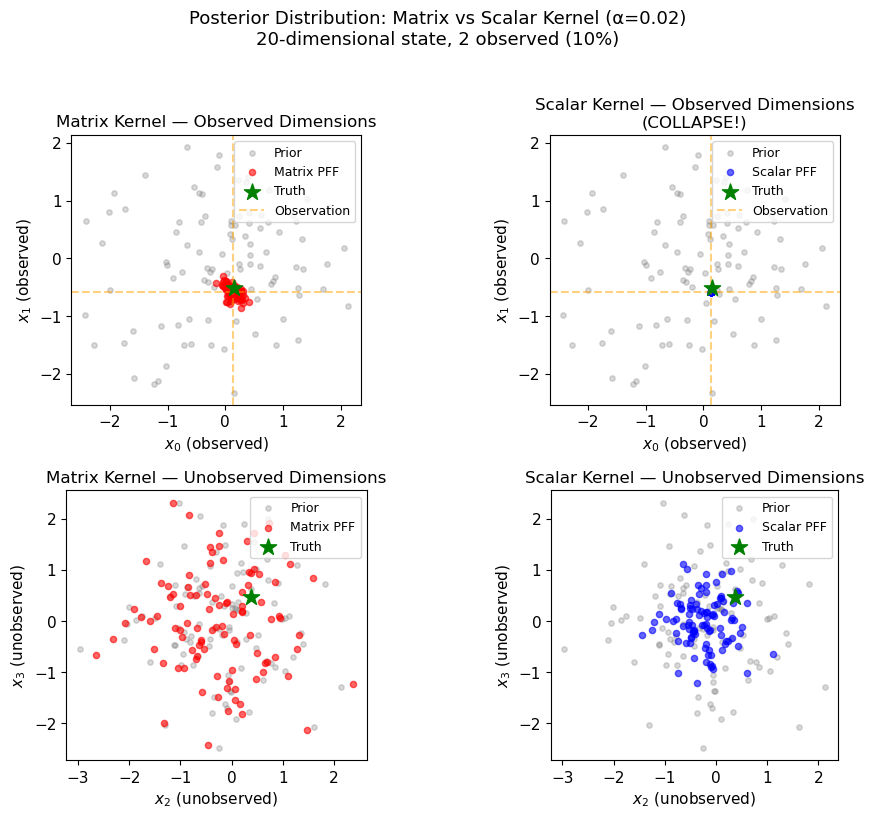

In [6]:
# Figure settings - tweak these!
fig_width = 10
fig_height = 8

prior_color = 'gray'
prior_alpha = 0.3
prior_size = 15

matrix_color = 'red'
matrix_alpha = 0.6
matrix_size = 20

scalar_color = 'blue'
scalar_alpha = 0.6
scalar_size = 20

truth_color = 'green'
truth_size = 150
truth_marker = '*'

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Indices for plotting
obs_idx = [0, 1]      # Observed dimensions
unobs_idx = [2, 3]    # First two unobserved dimensions

# --- Top-Left: Matrix Kernel, Observed Dims ---
ax = axes[0, 0]
ax.scatter(prior[:, obs_idx[0]], prior[:, obs_idx[1]], 
           c=prior_color, s=prior_size, alpha=prior_alpha, label='Prior')
ax.scatter(matrix_post[:, obs_idx[0]], matrix_post[:, obs_idx[1]], 
           c=matrix_color, s=matrix_size, alpha=matrix_alpha, label='Matrix PFF')
ax.scatter(x_true[obs_idx[0]], x_true[obs_idx[1]], 
           c=truth_color, s=truth_size, marker=truth_marker, label='Truth', zorder=10)
ax.axhline(y[1], color='orange', linestyle='--', alpha=0.5, label='Observation')
ax.axvline(y[0], color='orange', linestyle='--', alpha=0.5)
ax.set_xlabel(f'$x_0$ (observed)')
ax.set_ylabel(f'$x_1$ (observed)')
ax.set_title('Matrix Kernel — Observed Dimensions')
ax.legend(loc='upper right', fontsize=9)
ax.set_aspect('equal', adjustable='box')

# --- Top-Right: Scalar Kernel, Observed Dims ---
ax = axes[0, 1]
ax.scatter(prior[:, obs_idx[0]], prior[:, obs_idx[1]], 
           c=prior_color, s=prior_size, alpha=prior_alpha, label='Prior')
ax.scatter(scalar_post[:, obs_idx[0]], scalar_post[:, obs_idx[1]], 
           c=scalar_color, s=scalar_size, alpha=scalar_alpha, label='Scalar PFF')
ax.scatter(x_true[obs_idx[0]], x_true[obs_idx[1]], 
           c=truth_color, s=truth_size, marker=truth_marker, label='Truth', zorder=10)
ax.axhline(y[1], color='orange', linestyle='--', alpha=0.5, label='Observation')
ax.axvline(y[0], color='orange', linestyle='--', alpha=0.5)
ax.set_xlabel(f'$x_0$ (observed)')
ax.set_ylabel(f'$x_1$ (observed)')
ax.set_title('Scalar Kernel — Observed Dimensions\n(COLLAPSE!)')
ax.legend(loc='upper right', fontsize=9)
ax.set_aspect('equal', adjustable='box')

# --- Bottom-Left: Matrix Kernel, Unobserved Dims ---
ax = axes[1, 0]
ax.scatter(prior[:, unobs_idx[0]], prior[:, unobs_idx[1]], 
           c=prior_color, s=prior_size, alpha=prior_alpha, label='Prior')
ax.scatter(matrix_post[:, unobs_idx[0]], matrix_post[:, unobs_idx[1]], 
           c=matrix_color, s=matrix_size, alpha=matrix_alpha, label='Matrix PFF')
ax.scatter(x_true[unobs_idx[0]], x_true[unobs_idx[1]], 
           c=truth_color, s=truth_size, marker=truth_marker, label='Truth', zorder=10)
ax.set_xlabel(f'$x_2$ (unobserved)')
ax.set_ylabel(f'$x_3$ (unobserved)')
ax.set_title('Matrix Kernel — Unobserved Dimensions')
ax.legend(loc='upper right', fontsize=9)
ax.set_aspect('equal', adjustable='box')

# --- Bottom-Right: Scalar Kernel, Unobserved Dims ---
ax = axes[1, 1]
ax.scatter(prior[:, unobs_idx[0]], prior[:, unobs_idx[1]], 
           c=prior_color, s=prior_size, alpha=prior_alpha, label='Prior')
ax.scatter(scalar_post[:, unobs_idx[0]], scalar_post[:, unobs_idx[1]], 
           c=scalar_color, s=scalar_size, alpha=scalar_alpha, label='Scalar PFF')
ax.scatter(x_true[unobs_idx[0]], x_true[unobs_idx[1]], 
           c=truth_color, s=truth_size, marker=truth_marker, label='Truth', zorder=10)
ax.set_xlabel(f'$x_2$ (unobserved)')
ax.set_ylabel(f'$x_3$ (unobserved)')
ax.set_title('Scalar Kernel — Unobserved Dimensions')
ax.legend(loc='upper right', fontsize=9)
ax.set_aspect('equal', adjustable='box')

plt.suptitle(f'Posterior Distribution: Matrix vs Scalar Kernel (α={alpha_scalar})\n'
             f'{nx}-dimensional state, {ny} observed ({100*ny/nx:.0f}%)', 
             fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('kernel_comparison_figure3.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Effect of Observation Sparsity

Compare collapse behavior across different observation fractions.

In [7]:
# Test different sparsity levels
configs = [
    (4, 2, '50%'),
    (10, 2, '20%'),
    (20, 2, '10%'),
    (40, 2, '5%'),
]

alpha_test = 0.02
N = 500

results_sparsity = []

for nx, ny, pct in configs:
    model = make_sparse_obs_model(nx, ny)
    
    rng = default_rng(42)
    x_true = rng.standard_normal(nx) * 0.5
    y = model.obs_mean(x_true) + rng.multivariate_normal(np.zeros(ny), model.obs_cov)
    prior = rng.multivariate_normal(model.initial_mean, model.initial_cov, size=N)
    
    res = run_pff_comparison(model, prior, y, alpha_test, alpha_test, max_iter=200)
    
    results_sparsity.append({
        'nx': nx,
        'ny': ny,
        'pct': pct,
        'scalar_obs_std': np.mean(np.std(res['scalar_post'][:, :ny], axis=0)),
        'matrix_obs_std': np.mean(np.std(res['matrix_post'][:, :ny], axis=0)),
        'scalar_unobs_std': np.mean(np.std(res['scalar_post'][:, ny:], axis=0)),
        'matrix_unobs_std': np.mean(np.std(res['matrix_post'][:, ny:], axis=0)),
    })

# Display as table
print(f"Effect of Observation Sparsity (α={alpha_test})")
print("=" * 75)
print(f"{'Dim':>5} | {'Obs%':>5} | {'Scalar obs_std':>15} | {'Matrix obs_std':>15} | {'Collapse?':>10}")
print("-" * 75)
for r in results_sparsity:
    collapse = "YES" if r['scalar_obs_std'] < 0.01 else "no"
    print(f"{r['nx']:>5} | {r['pct']:>5} | {r['scalar_obs_std']:>15.4f} | {r['matrix_obs_std']:>15.4f} | {collapse:>10}")

Effect of Observation Sparsity (α=0.02)
  Dim |  Obs% |  Scalar obs_std |  Matrix obs_std |  Collapse?
---------------------------------------------------------------------------
    4 |   50% |          0.0711 |          0.1294 |         no
   10 |   20% |          0.0000 |          0.1303 |        YES
   20 |   10% |          0.0000 |          0.1278 |        YES
   40 |    5% |          0.0000 |          0.1267 |        YES


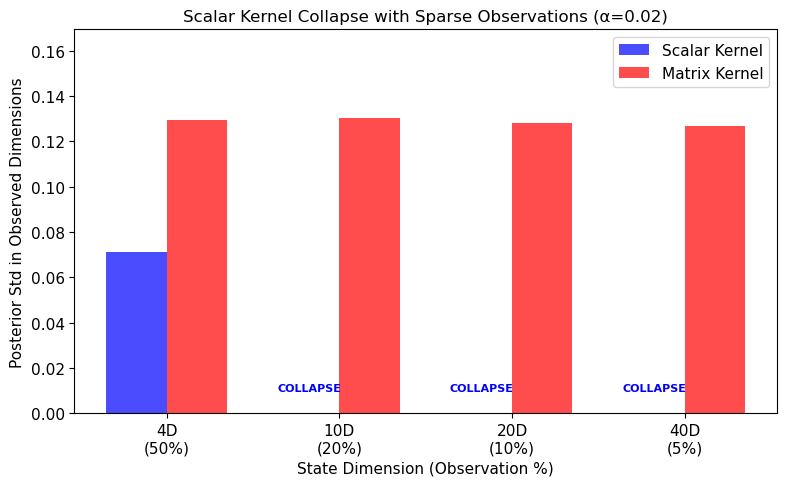

In [8]:
# Plot sparsity effect
fig, ax = plt.subplots(figsize=(8, 5))

x_labels = [f"{r['nx']}D\n({r['pct']})" for r in results_sparsity]
x_pos = np.arange(len(results_sparsity))
width = 0.35

scalar_vals = [r['scalar_obs_std'] for r in results_sparsity]
matrix_vals = [r['matrix_obs_std'] for r in results_sparsity]

bars1 = ax.bar(x_pos - width/2, scalar_vals, width, label='Scalar Kernel', color='blue', alpha=0.7)
bars2 = ax.bar(x_pos + width/2, matrix_vals, width, label='Matrix Kernel', color='red', alpha=0.7)

# Mark collapse
for i, val in enumerate(scalar_vals):
    if val < 0.01:
        ax.annotate('COLLAPSE', (x_pos[i] - width/2, val + 0.01), 
                   ha='center', fontsize=8, color='blue', fontweight='bold')

ax.set_xlabel('State Dimension (Observation %)')
ax.set_ylabel('Posterior Std in Observed Dimensions')
ax.set_title(f'Scalar Kernel Collapse with Sparse Observations (α={alpha_test})')
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels)
ax.legend()
ax.set_ylim(0, max(matrix_vals) * 1.3)

plt.tight_layout()
plt.savefig('sparsity_effect.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Effect of Kernel Bandwidth (α)

Show how increasing α prevents collapse for scalar kernel.

In [9]:
# Fixed model: 20D state, 2D observation
nx, ny = 10, 2
model = make_sparse_obs_model(nx, ny)

rng = default_rng(42)
x_true = rng.standard_normal(nx) * 0.5
y = model.obs_mean(x_true) + rng.multivariate_normal(np.zeros(ny), model.obs_cov)
prior = rng.multivariate_normal(model.initial_mean, model.initial_cov, size=N)

alphas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
results_alpha = []

for alpha in alphas:
    res = run_pff_comparison(model, prior, y, alpha, alpha, max_iter=200)
    results_alpha.append({
        'alpha': alpha,
        'scalar_obs_std': np.mean(np.std(res['scalar_post'][:, :ny], axis=0)),
        'matrix_obs_std': np.mean(np.std(res['matrix_post'][:, :ny], axis=0)),
    })

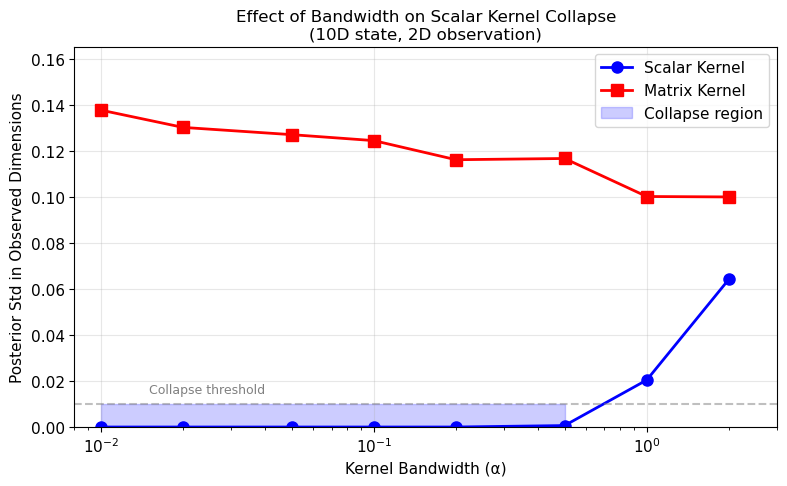

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(8, 5))

alpha_vals = [r['alpha'] for r in results_alpha]
scalar_stds = [r['scalar_obs_std'] for r in results_alpha]
matrix_stds = [r['matrix_obs_std'] for r in results_alpha]
ax.semilogx(alpha_vals, scalar_stds, 'b-o', label='Scalar Kernel', linewidth=2, markersize=8)
ax.semilogx(alpha_vals, matrix_stds, 'r-s', label='Matrix Kernel', linewidth=2, markersize=8)

# Mark collapse region
ax.axhline(0.01, color='gray', linestyle='--', alpha=0.5)
ax.text(0.015, 0.015, 'Collapse threshold', fontsize=9, color='gray')

ax.fill_between([0.01, 0.5], [0, 0], [0.01, 0.01], alpha=0.2, color='blue', label='Collapse region')

ax.set_xlabel('Kernel Bandwidth (α)')
ax.set_ylabel('Posterior Std in Observed Dimensions')
ax.set_title(f'Effect of Bandwidth on Scalar Kernel Collapse\n({nx}D state, {ny}D observation)')
ax.legend()
ax.set_xlim(0.008, 3)
ax.set_ylim(0, max(matrix_stds) * 1.2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bandwidth_effect.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary

### Key Findings (matching Hu 2021 Figures 2-3):

1. **Scalar kernel collapse**: When observations are sparse and bandwidth is small, the scalar kernel completely collapses the posterior in observed dimensions

2. **Root cause**: The scalar kernel uses full-state Mahalanobis distance. When particles are close in observed dims but far in unobserved dims, kernel value ≈ 0 → no repelling force → collapse

3. **Matrix kernel robustness**: Each dimension has independent kernel, so observed dims get proper repelling force regardless of unobserved dim spread

4. **Mitigation**: Larger bandwidth (α) helps scalar kernel avoid collapse, but matrix kernel is more robust across all settings